In [1]:
%%html
<style>


ol > li {
    color: red;
    font-weight: bold;
}


body{ 
  font-family: Helvetica !important;
}

h1 {
  color:red !important;
  background-color:lightskyblue !important;
  text-align:center;
}

.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}

code {
    font-family: monospace; 
    background-color:lavenderblush !important;
}

</style>

In [2]:
import datetime

print('Last Updated On: ', datetime.datetime.now(), ' Wellington, New Zealand')

Last Updated On:  2020-09-27 11:47:24.916232  Wellington, New Zealand


# Multi-class Random Forest classifier health data application

This notebook is based on the <a style="color:red;" href="https://drive.google.com/file/d/15L3PmghcwCCtMJNhE-LU-wf9YfvCK90W/view" target="_blank">*ICMR follow-up report, Section 3*</a>. We first run Random Forest classifiers on the imbalanced data and balanced data using only the Type of implant and Age group predictors, as previously done in the follow-up report. We then rerun the classifier as a full model (including all features) on the balanced data. In general, the procedures required for the former and latter are similar,

---
1. <span style="color:dodgerblue;font-weight:bold;">Prepare the data</span>
2. <span style="color:dodgerblue;font-weight:bold;">Split the data into training (80%) and test (20%) sets</span>
3. <span style="color:dodgerblue;font-weight:bold;">Train the model</span>
4. <span style="color:dodgerblue;font-weight:bold;">Perform ROC-AUC curves</span>
5. <span style="color:dodgerblue;font-weight:bold;">Obtain confusion matrix and performance metrics for the model</span>

---

Finally, this notebook uses the &#120536;&sup2; and F-scores statistical tests to determine the best features from the full model.

&rArr; Import the following libraries,

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [18]:
# data frame and arrays
import numpy as np
import pandas as pd

# plotting
import matplotlib
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_curve, auc

# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

# Training and test data module
from sklearn.model_selection import train_test_split

# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

# Oversampling method
from imblearn.over_sampling import SMOTE

# Other
from scipy import interp
from sklearn.preprocessing import LabelEncoder, label_binarize
from collections import Counter
import itertools
import random
from IPython.display import Image

# Feature importance
from sklearn.feature_selection import SelectKBest, chi2, f_classif

## About the data

&rArr; Prepare the data, 

In [5]:
data = pd.read_csv('hospdat.csv')
# delete columns 'Unnamed: 0', 'INFO' and 'Age'
data.drop(['Unnamed: 0', 'INFO', 'Age', 'ID', 'Last_followup'], axis=1, inplace=True)
# rename the outcome feature, 'Cause_of_redo' to 'Type_of_condition' and 'GROUP' to 'Type_of_implant'
data = data.rename(columns={'Cause_of_redo': 'Type_of_condition', 'GROUP':'Type_of_implant'})

data.replace(to_replace=['NHIP XOANG', 'RUNG NHI'],
           value=['Sinus arrhythmia', 'Atrial fibrillation'], 
           inplace=True)
data.head()

,Sex,Weight,Heart_rhythm,Type_of_implant,rct,hct,creatini,dvg1,fe1,paps1,...,infection,followup,fe2,dvg2,paps2,im2,Death2,Redo,Type_of_condition,Age_group
0,F,11.0,Sinus arrhythmia,NONE,65,35.0,38.0,55,57,60,...,0,26,62,42,30,1.5,alive,NO,NONE,0-4 yrs
1,F,5.0,Sinus arrhythmia,NONE,50,37.0,35.0,39,65,55,...,0,31,61,41,25,2.0,alive,NO,NONE,0-4 yrs
2,F,18.0,Sinus arrhythmia,BAND,55,40.0,30.0,58,68,75,...,0,242,67,41,30,3.5,alive,YES,MR,5-9 yrs
3,F,20.0,Sinus arrhythmia,RING,62,38.0,38.0,63,62,55,...,0,240,70,38,25,2.0,alive,NO,NONE,10-14 yrs
4,M,45.0,Sinus arrhythmia,RING,55,40.0,65.0,69,73,35,...,0,228,63,49,30,2.0,alive,NO,NONE,15-18 yrs


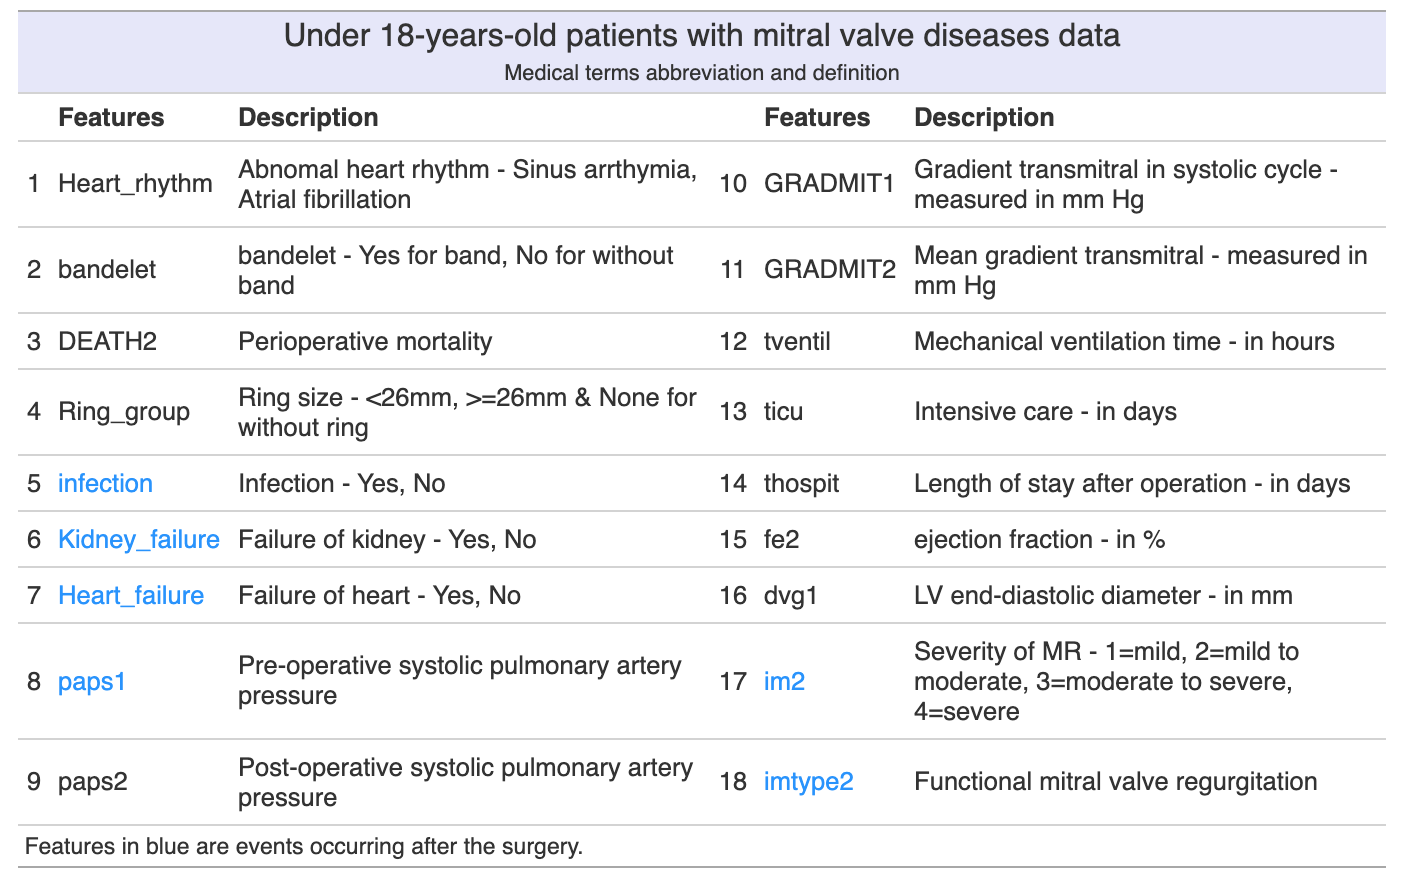

In [287]:
Image(filename='table1.png', width = 700)

## Descriptive statistics

The data has a total of 39 columns or features. This section describes some key correlations between features found in the data, using the modified confusion matrix function from the ```dython``` package.  

### Correlation matrix plotting the correlation coefficients between variables

In this example, the darker the color, the higher the correlation coefficient, i.e. dark wine red is equivalent to a correlation coefficient of 1. Since the coefficients are rounded as whole number (0 and 1) to fit in the matrix plot, some non-dark-wine-red colored cells will have a value of 1. Additionally, numbers with a minus sign are negative numbers potrayed as 0. 

In [6]:
"""https://github.com/shakedzy/dython/tree/master/dython"""

import math
import seaborn as sns
import scipy.stats as ss
import scipy.cluster.hierarchy as sch


def identify_columns_by_type(dataset, include):
    dataset = convert(dataset, 'dataframe')
    columns = list(dataset.select_dtypes(include=include).columns)
    return columns


def convert(data, to):
    converted = None
    if to == 'array':
        if isinstance(data, np.ndarray):
            converted = data
        elif isinstance(data, pd.Series):
            converted = data.values
        elif isinstance(data, list):
            converted = np.array(data)
        elif isinstance(data, pd.DataFrame):
            converted = data.as_matrix()
    elif to == 'list':
        if isinstance(data, list):
            converted = data
        elif isinstance(data, pd.Series):
            converted = data.values.tolist()
        elif isinstance(data, np.ndarray):
            converted = data.tolist()
    elif to == 'dataframe':
        if isinstance(data, pd.DataFrame):
            converted = data
        elif isinstance(data, np.ndarray):
            converted = pd.DataFrame(data)
    else:
        raise ValueError("Unknown data conversion: {}".format(to))
    if converted is None:
        raise TypeError(
            'cannot handle data conversion of type: {} to {}'.format(
                type(data), to))
    else:
        return converted


def remove_incomplete_samples(x, y):
    x = [v if v is not None else np.nan for v in x]
    y = [v if v is not None else np.nan for v in y]
    arr = np.array([x, y]).transpose()
    arr = arr[~np.isnan(arr).any(axis=1)].transpose()
    if isinstance(x, list):
        return arr[0].tolist(), arr[1].tolist()
    else:
        return arr[0], arr[1]


def replace_nan_with_value(x, y, value):
    x = np.array([v if v == v and v is not None else value for v in x])  # NaN != NaN
    y = np.array([v if v == v and v is not None else value for v in y])
    return x, y


_REPLACE = 'replace'
_DROP = 'drop'
_DROP_SAMPLES = 'drop_samples'
_DROP_FEATURES = 'drop_features'
_SKIP = 'skip'
_DEFAULT_REPLACE_VALUE = 0.0


def _inf_nan_str(x):
    if np.isnan(x):
        return 'NaN'
    elif abs(x) == np.inf:
        return 'inf'
    else:
        return ''


def conditional_entropy(x,
                        y,
                        nan_strategy=_REPLACE,
                        nan_replace_value=_DEFAULT_REPLACE_VALUE,
                        log_base: float = math.e):
    if nan_strategy == _REPLACE:
        x, y = replace_nan_with_value(x, y, nan_replace_value)
    elif nan_strategy == _DROP:
        x, y = remove_incomplete_samples(x, y)
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x, y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y / p_xy, log_base)
    return entropy


def cramers_v(x,
              y,
              bias_correction=True,
              nan_strategy=_REPLACE,
              nan_replace_value=_DEFAULT_REPLACE_VALUE):
    if nan_strategy == _REPLACE:
        x, y = replace_nan_with_value(x, y, nan_replace_value)
    elif nan_strategy == _DROP:
        x, y = remove_incomplete_samples(x, y)
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    if bias_correction:
        phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
        rcorr = r - ((r - 1) ** 2) / (n - 1)
        kcorr = k - ((k - 1) ** 2) / (n - 1)
        if min((kcorr - 1), (rcorr - 1)) == 0:
            warnings.warn(
                "Unable to calculate Cramer's V using bias correction. Consider using bias_correction=False",
                RuntimeWarning)
            return np.nan
        else:
            return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))
    else:
        return np.sqrt(phi2 / min(k - 1, r - 1))


def theils_u(x,
             y,
             nan_strategy=_REPLACE,
             nan_replace_value=_DEFAULT_REPLACE_VALUE):
    if nan_strategy == _REPLACE:
        x, y = replace_nan_with_value(x, y, nan_replace_value)
    elif nan_strategy == _DROP:
        x, y = remove_incomplete_samples(x, y)
    s_xy = conditional_entropy(x, y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n / total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x


def correlation_ratio(categories,
                      measurements,
                      nan_strategy=_REPLACE,
                      nan_replace_value=_DEFAULT_REPLACE_VALUE):
    if nan_strategy == _REPLACE:
        categories, measurements = replace_nan_with_value(
            categories, measurements, nan_replace_value)
    elif nan_strategy == _DROP:
        categories, measurements = remove_incomplete_samples(
            categories, measurements)
    categories = convert(categories, 'array')
    measurements = convert(measurements, 'array')
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat) + 1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0, cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array, n_array)) / np.sum(n_array)
    numerator = np.sum(
        np.multiply(n_array, np.power(np.subtract(y_avg_array, y_total_avg),
                                      2)))
    denominator = np.sum(np.power(np.subtract(measurements, y_total_avg), 2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator / denominator)
    return eta


def identify_nominal_columns(dataset):
    return identify_columns_by_type(dataset, include=['object', 'category'])


def identify_numeric_columns(dataset):
    return identify_columns_by_type(dataset, include=['int64', 'float64'])


def _comp_assoc(dataset, nominal_columns, mark_columns, theil_u, clustering,
                bias_correction, nan_strategy, nan_replace_value):
    """
    This is a helper function for compute_associations and associations
    """
    dataset = convert(dataset, 'dataframe')
    if nan_strategy == _REPLACE:
        dataset.fillna(nan_replace_value, inplace=True)
    elif nan_strategy == _DROP_SAMPLES:
        dataset.dropna(axis=0, inplace=True)
    elif nan_strategy == _DROP_FEATURES:
        dataset.dropna(axis=1, inplace=True)
    columns = dataset.columns
    if nominal_columns is None:
        nominal_columns = list()
    elif nominal_columns == 'all':
        nominal_columns = columns
    elif nominal_columns == 'auto':
        nominal_columns = identify_nominal_columns(dataset)

    corr = pd.DataFrame(index=columns, columns=columns)
    single_value_columns = []
    inf_nan = pd.DataFrame(data=np.zeros_like(corr),
                           columns=columns,
                           index=columns)
    for c in columns:
        if dataset[c].unique().size == 1:
            single_value_columns.append(c)
    for i in range(0, len(columns)):
        if columns[i] in single_value_columns:
            corr.loc[:, columns[i]] = 0.0
            corr.loc[columns[i], :] = 0.0
            continue
        for j in range(i, len(columns)):
            if columns[j] in single_value_columns:
                continue
            elif i == j:
                corr.loc[columns[i], columns[j]] = 1.0
            else:
                if columns[i] in nominal_columns:
                    if columns[j] in nominal_columns:
                        if theil_u:
                            ji = theils_u(
                                dataset[columns[i]],
                                dataset[columns[j]],
                                nan_strategy=_SKIP)
                            ij = theils_u(
                                dataset[columns[j]],
                                dataset[columns[i]],
                                nan_strategy=_SKIP)
                        else:
                            cell = cramers_v(dataset[columns[i]],
                                             dataset[columns[j]],
                                             bias_correction=bias_correction,
                                             nan_strategy=_SKIP)
                            ij = cell
                            ji = cell
                    else:
                        cell = correlation_ratio(dataset[columns[i]],
                                                 dataset[columns[j]],
                                                 nan_strategy=_SKIP)
                        ij = cell
                        ji = cell
                else:
                    if columns[j] in nominal_columns:
                        cell = correlation_ratio(dataset[columns[j]],
                                                 dataset[columns[i]],
                                                 nan_strategy=_SKIP)
                        ij = cell
                        ji = cell
                    else:
                        cell, _ = ss.pearsonr(dataset[columns[i]],
                                              dataset[columns[j]])
                        ij = cell
                        ji = cell
                corr.loc[columns[i], columns[j]] = ij if not np.isnan(ij) and abs(ij) < np.inf else 0.0
                corr.loc[columns[j], columns[i]] = ji if not np.isnan(ji) and abs(ji) < np.inf else 0.0
                inf_nan.loc[columns[i], columns[j]] = _inf_nan_str(ij)
                inf_nan.loc[columns[j], columns[i]] = _inf_nan_str(ji)
    corr.fillna(value=np.nan, inplace=True)
    if mark_columns:
        marked_columns = [
            '{} (nom)'.format(col)
            if col in nominal_columns else '{} (con)'.format(col)
            for col in columns
        ]
        corr.columns = marked_columns
        corr.index = marked_columns
        inf_nan.columns = marked_columns
        inf_nan.index = marked_columns
    if clustering:
        corr, _ = cluster_correlations(corr)
        columns = corr.columns
    return corr, columns, nominal_columns, inf_nan, single_value_columns


def compute_associations(dataset,
                         nominal_columns='auto',
                         mark_columns=False,
                         theil_u=False,
                         clustering=False,
                         bias_correction=True,
                         nan_strategy=_REPLACE,
                         nan_replace_value=_DEFAULT_REPLACE_VALUE,
                         ):
    corr, _, _, _, _ = _comp_assoc(dataset, nominal_columns, mark_columns, theil_u, clustering,
                                   bias_correction, nan_strategy, nan_replace_value)
    return corr


def associations2(dataset,
                 nominal_columns='auto',
                 mark_columns=False,
                 theil_u=False,
                 plot=True,
                 clustering=False,
                 bias_correction=True,
                 nan_strategy=_REPLACE,
                 nan_replace_value=_DEFAULT_REPLACE_VALUE,
                 ax=None,
                 figsize=None,
                 annot=True,
                 fmt='.2f',
                 cmap=None,
                 sv_color='silver',
                 cbar=True,
                 cbar_kws={"shrink": .72}
                 ):
    corr, columns, nominal_columns, inf_nan, single_value_columns = _comp_assoc(dataset, nominal_columns, mark_columns,
                                                                                theil_u, clustering, bias_correction,
                                                                                nan_strategy, nan_replace_value)
    if ax is None:
        plt.figure(figsize=figsize)
    if inf_nan.any(axis=None):
        inf_nan_mask = np.vectorize(lambda x: not bool(x))(inf_nan.values)
        ax = sns.heatmap(inf_nan_mask,
                         cmap=['white'],
                         annot=inf_nan if annot else None,
                         fmt='',
                         center=0,
                         square=True,
                         ax=ax,
                         mask=inf_nan_mask,
                         cbar=False)
    else:
        inf_nan_mask = np.ones_like(corr)
    if len(single_value_columns) > 0:
        sv = pd.DataFrame(data=np.zeros_like(corr),
                          columns=columns,
                          index=columns)
        for c in single_value_columns:
            sv.loc[:, c] = ' '
            sv.loc[c, :] = ' '
            sv.loc[c, c] = 'SV'
        sv_mask = np.vectorize(lambda x: not bool(x))(sv.values)
        ax = sns.heatmap(sv_mask,
                         cmap=[sv_color],
                         annot=sv if annot else None,
                         fmt='',
                         center=0,
                         square=True,
                         ax=ax,
                         mask=sv_mask,
                         cbar=False)
    else:
        sv_mask = np.ones_like(corr)
    mask = np.vectorize(lambda x: not bool(x))(inf_nan_mask) + np.vectorize(lambda x: not bool(x))(sv_mask)
    ax = sns.heatmap(corr,
                     cmap=cmap,
                     annot=annot,
                     fmt=fmt,
                     center=0,
                     vmax=1.0,
                     vmin=-1.0 if len(columns) - len(nominal_columns) >= 2 else 0.0,
                     square=True,
                     mask=mask,
                     ax=ax,
                     cbar=cbar,
                     cbar_kws=cbar_kws)
    if plot:
        plt.show()
    return {'ax': ax}

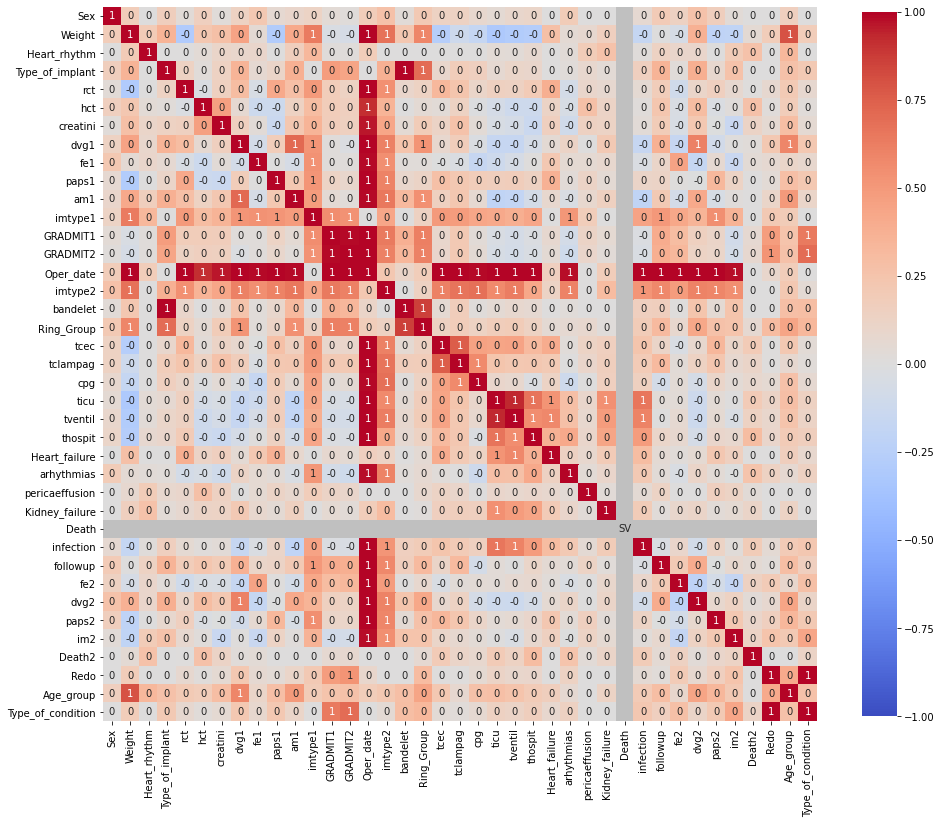

{'ax': <matplotlib.axes._subplots.AxesSubplot at 0x14095bee0>}

In [389]:
cols = list(data.columns.values) 
cols.pop(cols.index('Type_of_condition'))
df = data[cols+['Type_of_condition']] 
associations2(df, figsize=(16,18), cmap='coolwarm', fmt='.0f')

Looking at the correlation matrix, it is clear that ```Oper_date``` is highly correlated with many features. The graph below plots the distribution of Type of implant throughout the year, basing on each patient's operation date. It appears that C-E Ring implant is very common amongst the other options, both in the past and in the recent years. 

Text(0.5, 0, 'Operation date')

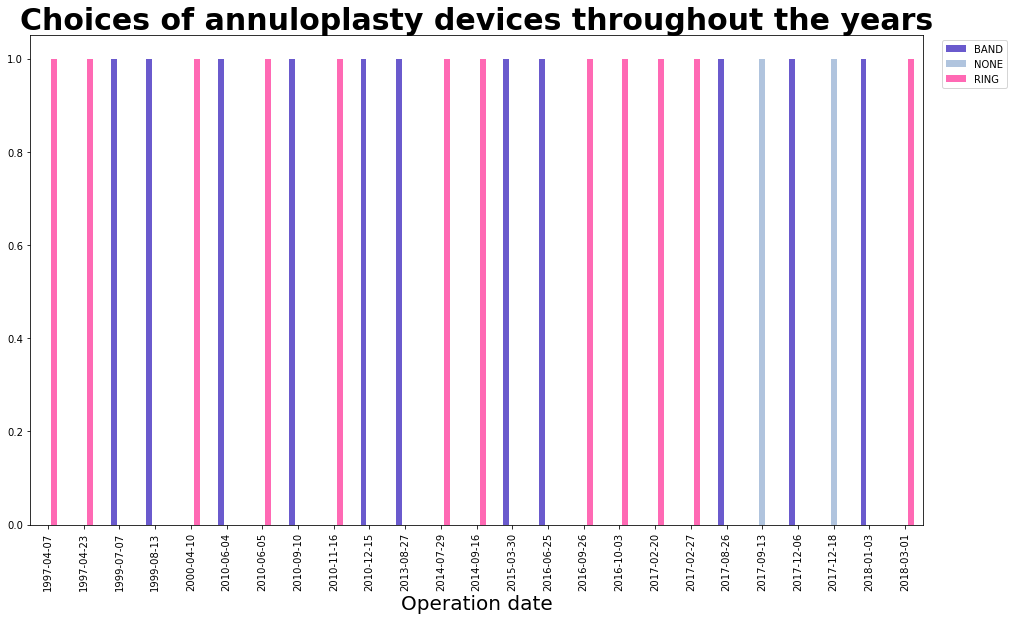

In [7]:
plt.rcParams["figure.figsize"] = [16,9]

colors = ['slateblue', 'lightsteelblue', 'hotpink']
dt = data[["Oper_date", "Type_of_implant"]]
dt = pd.DataFrame(dt)
dt = dt.tail(n=25)
(dt
 .groupby(['Oper_date', 'Type_of_implant'])
 .size()
 .unstack()
 .plot.bar(color=colors)
)
plt.legend(bbox_to_anchor=(1.1, 1.0))
plt.title(label='Choices of annuloplasty devices throughout the years', fontsize=30, fontweight="bold")
plt.xlabel('Operation date', fontsize=20)


### Connection between Redo variable and Type of condition variable

Additionally,```Redo``` (whether the patient has to have a re-operation) is highly correlated with the outcome variable, ```Type_of_condition```. That is, if a patient is not exposed to any condition, this means the patient won't have to undergo a further operation. For patients under the age of 18 years old that underwent mitral valve operation, the rate of re-operation seems to be higher in those with MS condition than MR condition. For patients with neither condition, the rate of re-operation is approximately 0%.

In [251]:
pd.crosstab(index=data["Redo"], 
            columns=data["Type_of_condition"])

Type_of_condition,MR,MS,NONE
Redo,,,
NO,0,0,95
YES,8,16,0


The following graph plots `Type_of_condition` against `Redo` using the information from the above table,

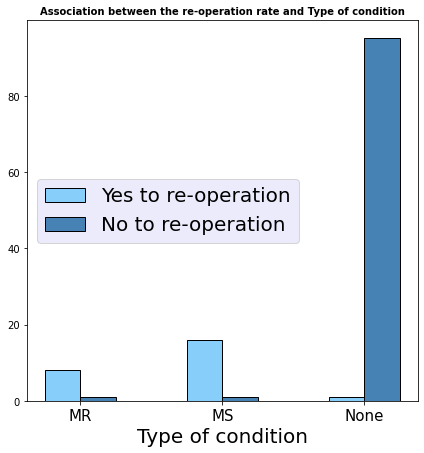

In [8]:
# set width of bar
barWidth = 0.25

plt.rcParams["figure.figsize"] = [7,7]


# set height of bar
bars2 = [1, 1, 95]
bars1 = [8, 16, 1]
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color='lightskyblue', width=barWidth, edgecolor='black', label='Yes to re-operation')
plt.bar(r2, bars2, color='steelblue', width=barWidth, edgecolor='black', label='No to re-operation')
 
# Add xticks on the middle of the group bars
plt.xlabel('Type of condition', fontsize=20)
plt.xticks([0.125, 1.125, 2.125], ['MR', 'MS', 'None'], fontsize=15)
plt.title(label='Association between the re-operation rate and Type of condition', fontsize=10, fontweight="bold")

# Create legend & Show graphic
plt.legend(loc = 6, fontsize=20, facecolor='lavender')

plt.show()

## Random forest classifier in `python`

As the data given is a multi-class problem, the `OnevsRestCLassifier` strategy where the class is fitted against all the other classes for each classifier or model, is applied simultaneously with the `RandomForestClassifier`. Some of the key parameters of the latter function are:
  * `n_estimator` - the number of trees in the forest
  * `max_depth` - the maximum depth of each tree
  * `random_state` - control the random number generator used, i.e. a random number generator seeded by the given integer. Using a seed will produce the same results across different calls.
  
In the next section, the classifier is used to analyse the data in three scenarios, imbalanced data with `Age group` and `Type of implant` predictors included in the model, balanced data with `Age group` and `Type of implant` predictors included in the model and balanced data with all predictors included in the model. 

The following function was implemented to perform step <span style="color:red;font-weight:bold;">2</span> to <span style="color:red;font-weight:bold;">5</span>,

In [23]:
# ROC-AUC curves function 

"""https://github.com/shakedzy/dython/tree/master/dython"""

def convert(data, to):
    converted = None
    if to == 'array':
        if isinstance(data, np.ndarray):
            converted = data
        elif isinstance(data, pd.Series):
            converted = data.values
        elif isinstance(data, list):
            converted = np.array(data)
        elif isinstance(data, pd.DataFrame):
            converted = data.as_matrix()
    elif to == 'list':
        if isinstance(data, list):
            converted = data
        elif isinstance(data, pd.Series):
            converted = data.values.tolist()
        elif isinstance(data, np.ndarray):
            converted = data.tolist()
    elif to == 'dataframe':
        if isinstance(data, pd.DataFrame):
            converted = data
        elif isinstance(data, np.ndarray):
            converted = pd.DataFrame(data)
    else:
        raise ValueError("Unknown data conversion: {}".format(to))
    if converted is None:
        raise TypeError(
            'cannot handle data conversion of type: {} to {}'.format(
                type(data), to))
    else:
        return converted


def remove_incomplete_samples(x, y):
    x = [v if v is not None else np.nan for v in x]
    y = [v if v is not None else np.nan for v in y]
    arr = np.array([x, y]).transpose()
    arr = arr[~np.isnan(arr).any(axis=1)].transpose()
    if isinstance(x, list):
        return arr[0].tolist(), arr[1].tolist()
    else:
        return arr[0], arr[1]


def replace_nan_with_value(x, y, value):
    x = np.array([v if v == v and v is not None else value for v in x])  # NaN != NaN
    y = np.array([v if v == v and v is not None else value for v in y])
    return x, y

def _display_roc_plot(xlim, ylim, legend):
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel('False Positive Rate', fontsize=15)
    plt.ylabel('True Positive Rate', fontsize=15)
    plt.title('ROC-AUC Curves', fontsize=25, loc='right')
    if legend:
        plt.legend(loc=legend, fontsize=13)
    plt.show()


def _draw_estimated_optimal_threshold_mark(fpr, tpr, thresholds, color, ms, fmt, ax):
    annotation_offset = (-.027, .03)
    a = np.zeros((len(fpr), 2))
    a[:, 0] = fpr
    a[:, 1] = tpr
    dist = lambda row: row[0]**2 + (1 - row[1])**2
    amin = np.apply_along_axis(dist, 1, a).argmin()
    plt.plot(fpr[amin], tpr[amin], color=color, marker='o', ms=ms)
    ax.annotate("{th:{fmt}}".format(th=thresholds[amin], fmt=fmt),
                xy=(fpr[amin], tpr[amin]), color=color,
                xytext=(fpr[amin]+annotation_offset[0],
                        tpr[amin]+annotation_offset[1]),
                size=14, weight='bold')
    return thresholds[amin]


def _plot_macro_roc(fpr, tpr, n, lw, fmt, ax):
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n
    fpr_macro = all_fpr
    tpr_macro = mean_tpr
    auc_macro = auc(fpr_macro, tpr_macro)
    label = 'ROC curve: macro (AUC = {auc:{fmt}})'.format(auc=auc_macro, fmt=fmt)
    ax.plot(fpr_macro,
            tpr_macro,
            label=label,
            color='navy',
            ls=':',
            lw=lw)


def _binary_roc_graph(y_true, y_pred, eoptimal, class_label, color, lw, ls, ms, fmt, ax):
    y_true = convert(y_true, 'array')
    y_pred = convert(y_pred, 'array')
    if y_pred.shape != y_true.shape:
        raise ValueError('y_true and y_pred must have the same shape')
    elif len(y_pred.shape) == 1:
        y_t = y_true
        y_p = y_pred
    else:
        y_t = [np.argmax(x) for x in y_true]
        y_p = [x[1] for x in y_pred]
    fpr, tpr, th = roc_curve(y_t, y_p)
    auc_score = auc(fpr, tpr)
    if class_label is not None:
        class_label = ': ' + class_label
    else:
        class_label = ''
    label = 'ROC curve{class_label} (AUC = {auc:{fmt}}'.format(class_label=class_label, auc=auc_score, fmt=fmt)
    if eoptimal:
        eopt = _draw_estimated_optimal_threshold_mark(fpr, tpr, th, color, ms, fmt, ax)
        label += ', eOpT = {th:{fmt}})'.format(th=eopt, fmt=fmt)
    else:
        eopt = None
        label += ')'
    ax.plot(fpr,
            tpr,
            color=color,
            lw=lw,
            ls=ls,
            label=label)
    return {'fpr': fpr, 'tpr': tpr, 'thresholds': th,
            'auc': auc_score, 'eopt': eopt}


def roc_plot(y_true,
              y_pred,
              micro=True,
              macro=True,
              eopt=True,
              class_names=None,
              colors=None,
              ax=None,
              figsize=None,
              xlim=(0.,1.),
              ylim=(0.,1.02),
              lw=2,
              ls='-',
              ms=10,
              fmt='.2f',
              legend='best',
              plot=True
              ):
    all_fpr = list()
    all_tpr = list()
    y_true = convert(y_true, 'array')
    y_pred = convert(y_pred, 'array')
    if y_pred.shape != y_true.shape:
        raise ValueError('y_true and y_pred must have the same shape')
    if class_names is not None:
        if not isinstance(class_names, str):
            class_names = convert(class_names, 'list')
        else:
            class_names = [class_names]
    if ax is None:
        plt.figure(figsize=figsize)
        ax = plt.gca()
    colors = colors or ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'darkorange']
    output_dict = dict()
    if len(y_pred.shape) == 1 or y_pred.shape[1] <= 2:
        class_label = class_names[-1] if class_names is not None else None
        d = _binary_roc_graph(y_true, y_pred, eoptimal=eopt,
                              class_label=class_label, color=colors[-1],
                              lw=lw, ls=ls, ms=ms, fmt=fmt, ax=ax)
        class_label = class_label or '0'
        output_dict[class_label] = {'auc': d['auc'],
                                    'eopt': d['eopt']}
    else:
        n = y_pred.shape[1]
        if class_names is not None:
            if not isinstance(class_names, list):
                raise ValueError('class_names must be a list of items in multi-class classification.')
            if len(class_names) != n:
                raise ValueError('Number of class names does not match input data size.')
        for i in range(0, n):
            class_label = class_names[i] if class_names is not None else str(i)
            d = _binary_roc_graph(y_true[:, i],
                                  y_pred[:, i],
                                  eoptimal=eopt,
                                  color=colors[i % len(colors)],
                                  class_label=class_label,
                                  lw=lw, ls=ls, ms=ms, fmt=fmt, ax=ax)
            all_fpr.append(d['fpr'])
            all_tpr.append(d['tpr'])
            output_dict[class_label] = {'auc': d['auc'],
                                        'eopt': d['eopt']}
        if micro:
            _binary_roc_graph(y_true.ravel(),
                              y_pred.ravel(),
                              eoptimal=False,
                              ls=':',
                              color='deeppink',
                              class_label='micro',
                              lw=lw, ms=ms, fmt=fmt, ax=ax)
        if macro:
            _plot_macro_roc(all_fpr, all_tpr, n, lw, fmt, ax)
    if plot:
        _display_roc_plot(xlim=xlim, ylim=ylim, legend=legend)
    output_dict['ax'] = ax
    return output_dict


# Confusion matrix function

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    #cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw, fraction=0.046, pad=0.04)
    #cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels, fontweight='bold', fontsize=13)
    ax.set_yticklabels(row_labels, fontweight='bold', fontsize=13)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), ha="center")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    
    ax.set_ylabel('True label', fontsize=12)
    ax.set_xlabel('Predicted label', fontsize=12, labelpad=10)
    ax.xaxis.set_label_position('top')


    return im


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw, fontsize=15)
            texts.append(text)

    return texts

In [21]:
plt.rcParams['axes.facecolor'] = 'aliceblue'

y = LabelEncoder().fit_transform(data["Type_of_condition"])
classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=5, max_depth=4, random_state=0))

colors = ['darkslateblue', 'cornflowerblue', 'dodgerblue']

target_names = ["MR", "MS", "None"]

oversample = SMOTE()

random.seed(112)


def rf_function(X, 
                y = y, 
                classifier = classifier,
                ):
    
    X = X.apply(LabelEncoder().fit_transform)
    
    # if oversamp = True, over-sample to balance the data
    if oversamp:
        X, y = oversample.fit_resample(X, y)
        y = label_binarize(y, classes=[0,1,2])
        
    # Step 2 - Split the data into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)
    else: 
        y = label_binarize(y, classes=[0,1,2])
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)
    
    # Step 3 - Train the model 
    full_model = classifier.fit(X_train, y_train)
    y_pred = classifier.predict_proba(X_test)

    s = 0

    for i in range(y_test.shape[0]):
        if y_test[i,:].argmax() == y_pred[i,:].argmax():
            s += 1
    label1 = print("\n",'\033[36m' + '\033[1m' + 'Output 1:',  '\033[0m' + 'Correct predictions based on test data')
    predictions = print('      {0}/{1} ({2:.2f}%)'.format(s, y_test.size, 100.0*s/y_test.size))
    
    # Step 4 - Produce ROC-AUC curves for each class
    label2 = print("\n", '\033[36m' + '\033[1m' + 'Output 2:',  '\033[0m' + "ROC-AUC curves for each class")
    rplot = roc_plot(y_test, y_pred, class_names = target_names, figsize=(10,10), colors=colors)
    
    fig, ax = plt.subplots()

    y_true = np.argmax(y_test, axis=1)
    y_pred = np.argmax(y_pred, axis=1)
    
    # Step 5 - Obtain confusion matrix and performance metrix
    CM = confusion_matrix(y_true, y_pred)

    im = heatmap(CM, target_names, target_names, ax=ax,
                   cmap="Blues", cbarlabel="")
    texts = annotate_heatmap(im, valfmt="{x}")
    
    label3 = print("\n", '\033[36m' + '\033[1m' + 'Output 3:', '\033[0m' + "3x3 Confusion matrix")
    fig = plt.figure(figsize=(8, 6))
    plt.show()
    
    label4 = print('\n', '\033[36m' + '\033[1m' + 'Output 4:', '\033[0m' + "Performance metrics")
    metrics = print(classification_report(y_true, y_pred, target_names=target_names))
        
    return {'predictions': predictions, 'label2': label2, 
            'roc_plot': rplot, 'label3': label3, 'labels4':label4, 
            'metrics': metrics}


## Data included only two predictors : Type of implant and Age group

Throughout this notebook, the classes of the outcome variable will often be referred as 0, 1 and 2 for "MR", "MS" and "None", respectively.

### Imbalanced data

Class=2, n=95 (79.832%)
Class=0, n=8 (6.723%)
Class=1, n=16 (13.445%)


[Text(0, 0, 'NONE'), Text(0, 0, 'MS'), Text(0, 0, 'MR')]

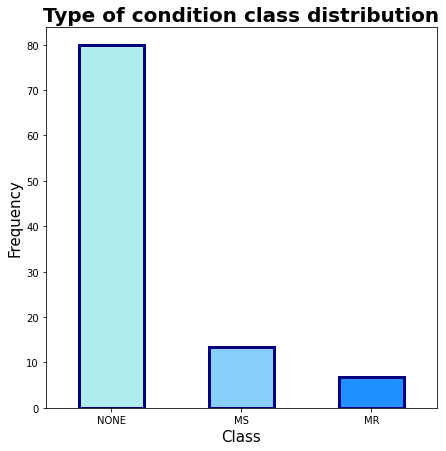

In [13]:
y = LabelEncoder().fit_transform(data["Type_of_condition"])       # outcome

counter = Counter(y)

for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

# class 2 = 'NONE', class 1 = 'MS', class 0 = 'MR'
frequencies = [79.832, 13.445, 6.723]
freq_series = pd.Series(frequencies)

# Plot the figure
plt.rcParams["figure.figsize"] = [7,7]
plt.rcParams['axes.facecolor'] = 'white'

my_colors = ['paleturquoise', 'lightskyblue', 'dodgerblue']
plot = freq_series.plot(kind='bar', rot=0,color=my_colors, edgecolor='navy', linewidth=3)
plot.set_title('Type of condition class distribution', fontsize=20, fontweight='bold')
plot.set_xlabel('Class', fontsize=15)
plot.set_ylabel('Frequency', fontsize=15)
x_labels = ["NONE", "MS", "MR"]
plot.set_xticklabels(x_labels)

As seen in the above plot, class **None** has 95 observations, class **MS** has 16 observations and class **MR** has 8 observations so the data given is very highly imbalanced. The results from fitting the Random Forest classifier to this data are as follows, 


 Output 1: Correct predictions based on test data
      17/72 (23.61%)

 Output 2: ROC-AUC curves for each class


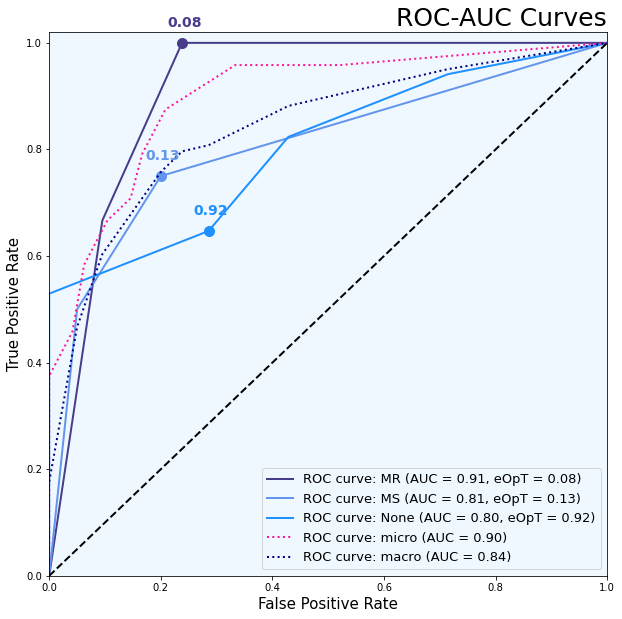


 Output 3: 3x3 Confusion matrix


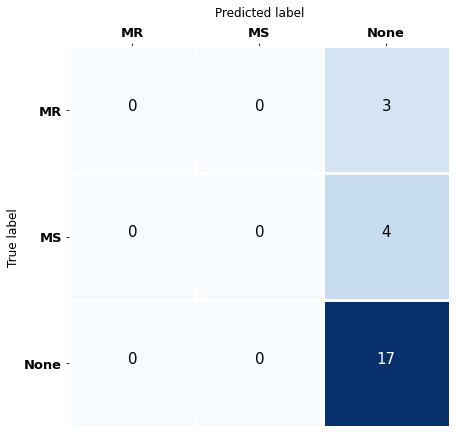

<Figure size 576x432 with 0 Axes>


 Output 4: Performance metrics
              precision    recall  f1-score   support

          MR       0.00      0.00      0.00         3
          MS       0.00      0.00      0.00         4
        None       0.71      1.00      0.83        17

    accuracy                           0.71        24
   macro avg       0.24      0.33      0.28        24
weighted avg       0.50      0.71      0.59        24



{'predictions': None,
 'label2': None,
 'roc_plot': {'MR': {'auc': 0.9126984126984127, 'eopt': 0.07908496732026143},
  'MS': {'auc': 0.8062500000000001, 'eopt': 0.13295740207504914},
  'None': {'auc': 0.8025210084033614, 'eopt': 0.9209150326797385},
  'ax': <matplotlib.axes._subplots.AxesSubplot at 0x127d10910>},
 'label3': None,
 'labels4': None,
 'metrics': None}

In [24]:
X = data[['Age_group', 'Type_of_implant']]   # Age_group and Type of implant predictors only model

oversamp = False                             # imbalanced data, ignoring SMOTE oversampling method

rf_function(X = X)

---

## Balanced data

&rArr; Apply SMOTE for imbalanced classification to balance the data. In particular, SMOTE will oversample all classes to have 95 observations.

In [429]:
random.seed(112)
oversample = SMOTE()
y = LabelEncoder().fit_transform(data["Type_of_condition"])       # outcome
X, y = oversample.fit_resample(x, y)

counter = Counter(y)
for k,v in counter.items():
    per = v / len(Y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=2, n=95 (79.832%)
Class=0, n=95 (79.832%)
Class=1, n=95 (79.832%)



 Output 1: Correct predictions based on test data
      41/171 (23.98%)

 Output 2: ROC-AUC curves for each class


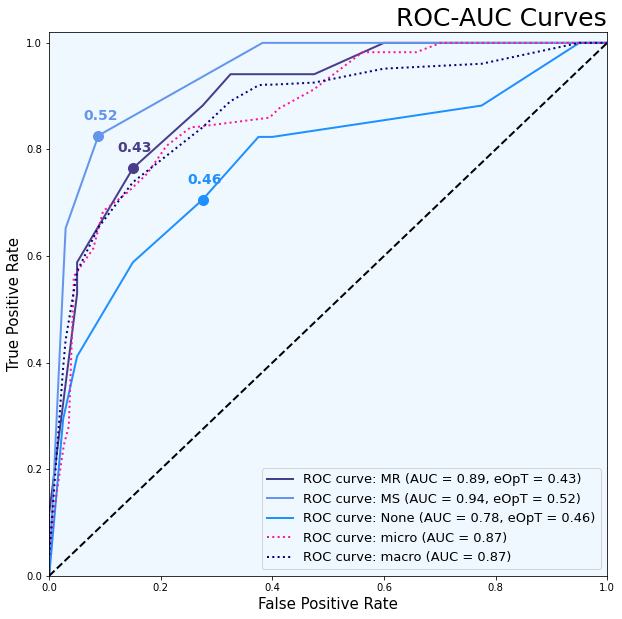


 Output 3: 3x3 Confusion matrix


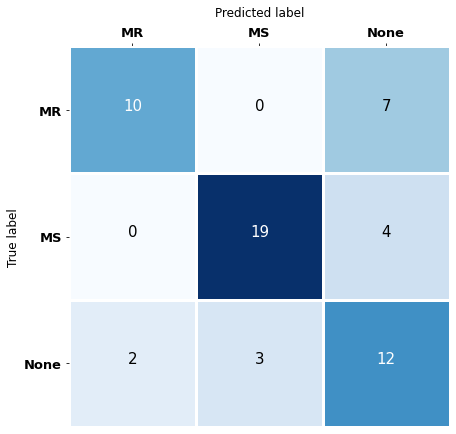

<Figure size 576x432 with 0 Axes>


 Output 4: Performance metrics
              precision    recall  f1-score   support

          MR       0.83      0.59      0.69        17
          MS       0.86      0.83      0.84        23
        None       0.52      0.71      0.60        17

    accuracy                           0.72        57
   macro avg       0.74      0.71      0.71        57
weighted avg       0.75      0.72      0.73        57



{'predictions': None,
 'label2': None,
 'roc_plot': {'MR': {'auc': 0.8948529411764705, 'eopt': 0.42985421785421785},
  'MS': {'auc': 0.9392583120204604, 'eopt': 0.5233598049460119},
  'None': {'auc': 0.775, 'eopt': 0.4579794768030062},
  'ax': <matplotlib.axes._subplots.AxesSubplot at 0x127aa7040>},
 'label3': None,
 'labels4': None,
 'metrics': None}

In [25]:
X = data[['Age_group', 'Type_of_implant']] 

oversamp = True                              # imbalanced data, ignoring SMOTE oversampling method

rf_function(X = X)


## Full model

The results from the full model of balanced data are as follows:


 Output 1: Correct predictions based on test data
      57/171 (33.33%)

 Output 2: ROC-AUC curves for each class


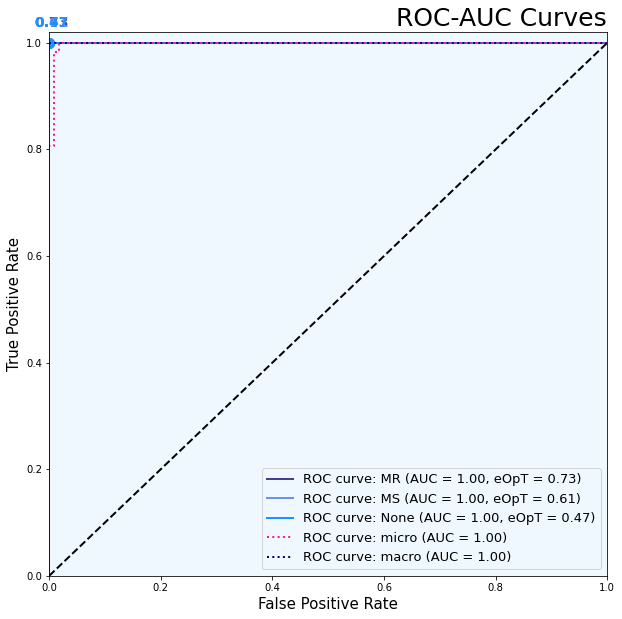


 Output 3: 3x3 Confusion matrix


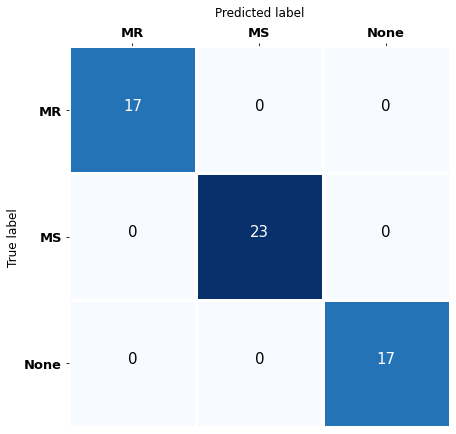

<Figure size 576x432 with 0 Axes>


 Output 4: Performance metrics
              precision    recall  f1-score   support

          MR       1.00      1.00      1.00        17
          MS       1.00      1.00      1.00        23
        None       1.00      1.00      1.00        17

    accuracy                           1.00        57
   macro avg       1.00      1.00      1.00        57
weighted avg       1.00      1.00      1.00        57



{'predictions': None,
 'label2': None,
 'roc_plot': {'MR': {'auc': 1.0, 'eopt': 0.7305555555555555},
  'MS': {'auc': 1.0, 'eopt': 0.6050735471425127},
  'None': {'auc': 1.0, 'eopt': 0.46618357487922707},
  'ax': <matplotlib.axes._subplots.AxesSubplot at 0x1275180a0>},
 'label3': None,
 'labels4': None,
 'metrics': None}

In [26]:
X = data.drop(columns=['Type_of_condition'], axis=1)

oversamp = True                              # imbalanced data, ignoring SMOTE oversampling method

rf_function(X = X)

Finally, we will look at the top 15 most informative features based on $\color{black}{\chi^2}$ and *F1-score* statistics which are independent from the Random Forest classifier. The results from both tests show that `Type_of_implant`, `Ring_Group`, `GRADMIT1`, `GRADMIT2`, `im2`, `fe2`, `paps1`, `dvg1` and `thospit` are informative and hence have a marked influence on the outcome variable, **Type of condition**. 

<h3 style ="font-style:italic;"><math>&#120536;&sup2;</math> test</h3>

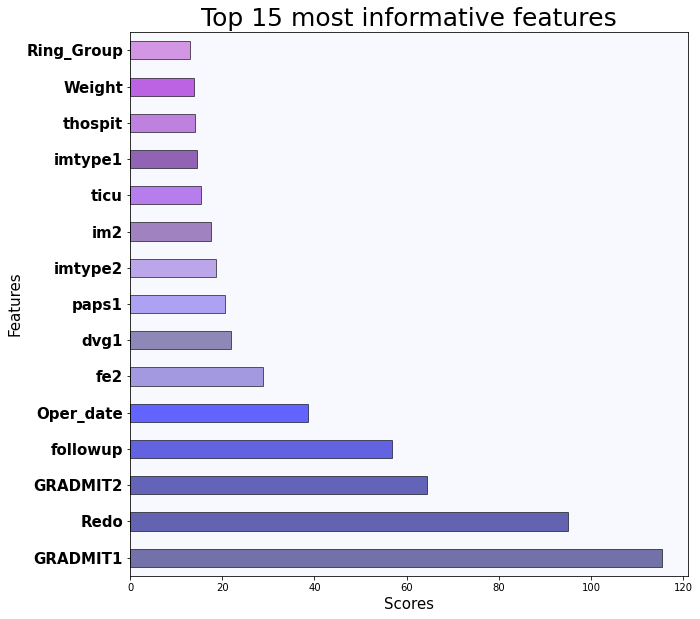

In [30]:
test = SelectKBest(score_func=chi2, k=4)

#Fit the function for ranking the features by score

X = data.drop(columns=['Type_of_condition'], axis=1)
X = X.apply(LabelEncoder().fit_transform)

fit = test.fit(X, y)

#Summarize scores
np.set_printoptions(suppress=True)

new_X = pd.DataFrame(data = X.columns)
new_X["scores"] = fit.scores_
new_X.columns = ['Features', 'Scores']
top15 = new_X.nlargest(15,'Scores')

plt.rcParams["figure.figsize"] = [10,10]
plt.rcParams['axes.facecolor'] = 'ghostwhite'

top15.plot.barh(x='Features', y='Scores',
                color=['midnightblue', 'navy', 'darkblue', 'mediumblue', 'blue', 
                       'slateblue', 'darkslateblue', 'mediumslateblue', 'mediumpurple','rebeccapurple',
                       'blueviolet', 'indigo', 'darkorchid', 'darkviolet', 'mediumorchid'], legend=None, edgecolor = 'black', alpha=0.6)
plt.xlabel('Scores', fontsize= 15)
plt.yticks(fontsize= 15, fontweight='bold')
plt.ylabel('Features', fontsize= 15)
plt.title(label = 'Top 15 most informative features', fontsize=25)
plt.show()

<h3 style ="font-style:italic;color:black;">F-score test</h3>

In [298]:
X = data.drop(columns=['Type_of_condition'], axis=1)
X = X.apply(LabelEncoder().fit_transform)
y = LabelEncoder().fit_transform(data["Type_of_condition"])

# Select 5 features with top 5 Fisher scores
selector = SelectKBest(f_classif, k = 15)

X_new = selector.fit_transform(X, y)
names = X.columns.values[selector.get_support()]
scores = selector.scores_[selector.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Features', 'F_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Features'], ascending = [False, True])

display(ns_df_sorted)

,Features,F_Scores
13,Redo,inf
11,im2,13.487900
6,Ring_Group,12.704233
3,GRADMIT1,7.673346
0,Type_of_implant,6.878487
5,bandelet,6.720794
4,GRADMIT2,6.505237
9,fe2,5.835634
14,Age_group,5.273482
2,paps1,3.612316


---
## Results summary 

The performance metrics, AUC, accuracy and F1-score for each model are summarised in the below table. For the number of correct predictions (reported in percentage) for the test data, the results are 23.61%, 24.56% and 33.33% for the non-full imbalanced model, non-full balanced model and full balanced model, respectively.

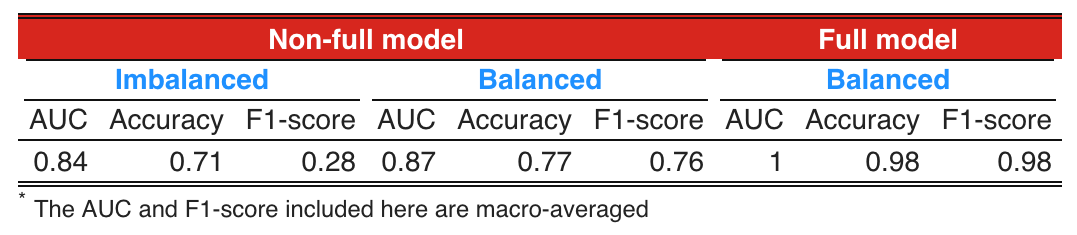

In [281]:
Image(filename='table2.png', width = 600)